In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
plt.style.use('dark_background')

In [26]:
# Creating some data
x_train = np.array([ *np.random.multivariate_normal((1,0), 1e-2*np.eye(2), 80),  *np.random.multivariate_normal((0,1), 1e-2*np.eye(2), 80)])
y_train = np.array([*-np.ones(80), *np.ones(80)])
x_test = np.array([ *np.random.multivariate_normal((1,0), 1e-2*np.eye(2), 20),  *np.random.multivariate_normal((0,1), 1e-2*np.eye(2), 20)])
y_test = np.array([*-np.ones(20), *np.ones(20)])

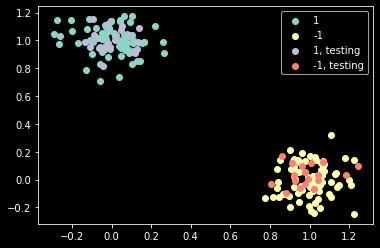

In [27]:
fig, ax = plt.subplots()
ax.scatter( x_train[ y_train == 1, 0], x_train[y_train == 1, 1], label = 1)
ax.scatter( x_train[ y_train == -1, 0], x_train[y_train == -1, 1], label = -1)

ax.scatter( x_test[ y_test == 1, 0], x_test[y_test == 1, 1], label = "1, testing")
ax.scatter( x_test[ y_test == -1, 0], x_test[y_test == -1, 1], label = "-1, testing")

ax.legend()
plt.show()

In [28]:
from svm_numpy import svm

# Soft Margin SVM

In [29]:
n_epochs = 100
clf = svm(100)
clf.fit(x_train, y_train, epochs = n_epochs, batch_size = 4, learning_rate = 0.001, momentum = 0.9)
print(f"The accuracy of our model is {clf.accuracy(x_test, y_test)}")

The accuracy of our model is 1.0


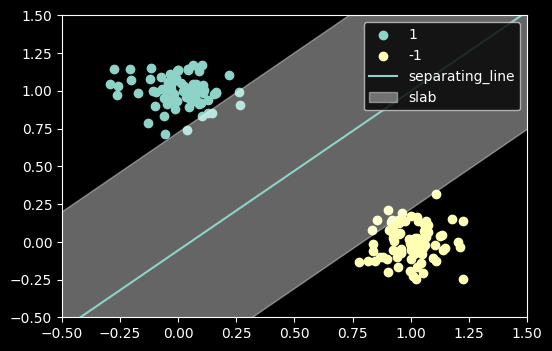

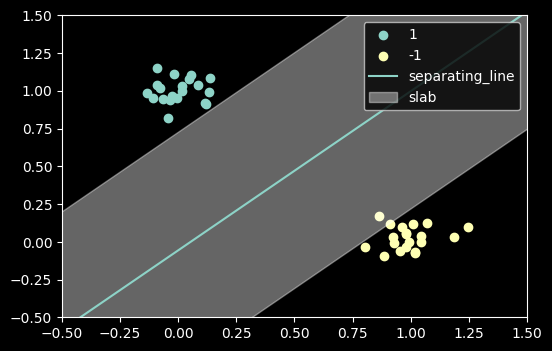

In [30]:
_ = clf.display(x_train,y_train, dpi = 100)
_ = clf.display(x_test, y_test, dpi = 100)

## Below is the result obtained from sklearn svm

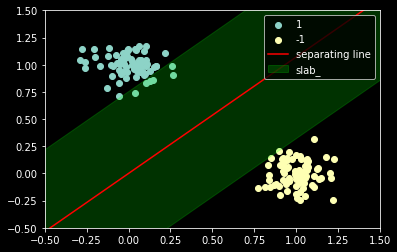

In [31]:

from sklearn.svm import SVC
skl_svm = SVC(kernel = 'linear')
skl_svm.fit(x_train, y_train)

x_coords = np.array([-0.6,1.6])
find_y = lambda x,w,b : (-b-w[0]*x)/w[1]

fig,ax = plt.subplots()
ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.5,1.5)
ax.scatter( x_train[ y_train == 1, 0], x_train[y_train == 1, 1], label = 1)
ax.scatter( x_train[ y_train == -1, 0], x_train[y_train == -1, 1], label = -1)

ax.plot( x_coords, find_y(x_coords, skl_svm.coef_[0], skl_svm.coef0), label = "separating line", color='red' )
dist = 1/skl_svm.coef_[0][1]
ax.fill_between(x_coords, find_y(x_coords, skl_svm.coef_[0], skl_svm.coef0) - dist, find_y(x_coords, skl_svm.coef_[0], skl_svm.coef0)+dist, label = "slab_", edgecolor = None, alpha=0.2, color='lime')
ax.legend()
plt.show()

# Hard Margin SVM

In [32]:
n_epochs = 100
clf = svm(1e9)
clf.fit(x_train, y_train, epochs = n_epochs, batch_size = 4, learning_rate = 0.001, momentum=0.9)
print(f"The accuracy of our model is {clf.accuracy(x_test, y_test)}")

The accuracy of our model is 1.0


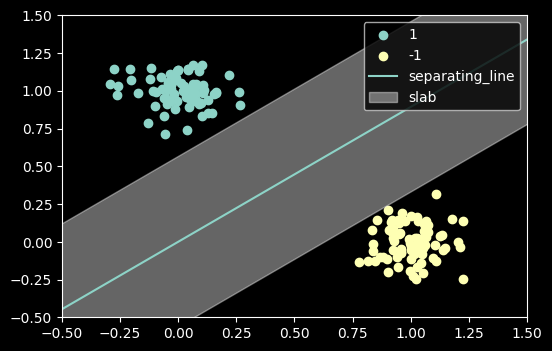

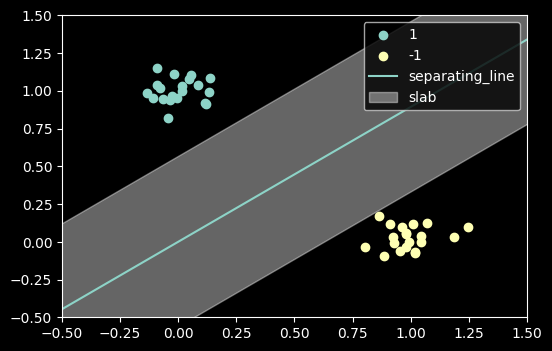

In [33]:
_ = clf.display(x_train,y_train, dpi = 100)
_ = clf.display(x_test, y_test, dpi = 100)

Uncomment the next cell to generate gif, use fig = True in clf.fit to generate images

In [34]:
# import imageio
# with imageio.get_writer('../results/animation.gif', mode='I',) as writer:
#     for filename in range(n_epochs):
#         image = imageio.imread(f'fig/{filename}.png')
#         writer.append_data(image)
# _ = os.system("xdg-open ../results/animation.gif")

# Illustration for soft margin SVM

In [35]:
# Soft margin
# Creating some data
x_train = np.array([ *np.random.multivariate_normal((1,0), 0.5*np.eye(2), 80),  *np.random.multivariate_normal((0,1), 0.5*np.eye(2), 80)])
y_train = np.array([*-np.ones(80), *np.ones(80)])
x_test = np.array([ *np.random.multivariate_normal((1,0), 0.5*np.eye(2), 20),  *np.random.multivariate_normal((0,1), 0.5*np.eye(2), 20)])
y_test = np.array([*-np.ones(20), *np.ones(20)])

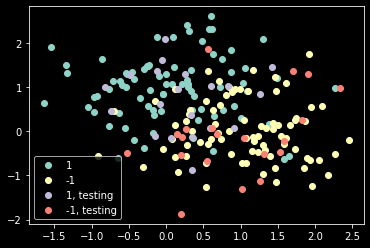

In [36]:
fig, ax = plt.subplots()
ax.scatter( x_train[ y_train == 1, 0], x_train[y_train == 1, 1], label = 1)
ax.scatter( x_train[ y_train == -1, 0], x_train[y_train == -1, 1], label = -1)

ax.scatter( x_test[ y_test == 1, 0], x_test[y_test == 1, 1], label = "1, testing")
ax.scatter( x_test[ y_test == -1, 0], x_test[y_test == -1, 1], label = "-1, testing")

ax.legend()
plt.show()

In [37]:
n_epochs = 5000
clf = svm(100)
clf.fit(x_train, y_train, epochs = n_epochs, batch_size = 4, learning_rate = 0.01)
print(f"The accuracy of our model is {clf.accuracy(x_test, y_test)}")

The accuracy of our model is 0.8


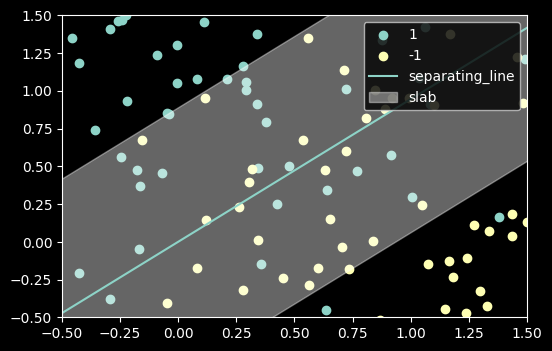

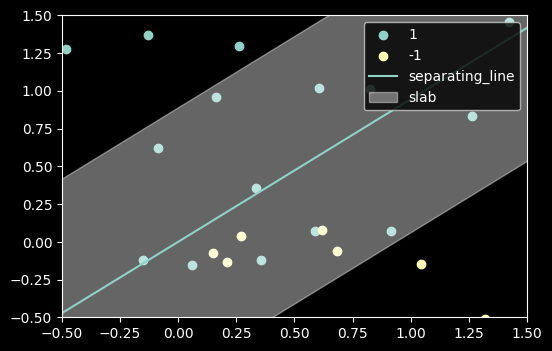

In [38]:
_ = clf.display(x_train,y_train, dpi = 100)
_ = clf.display(x_test, y_test, dpi = 100)

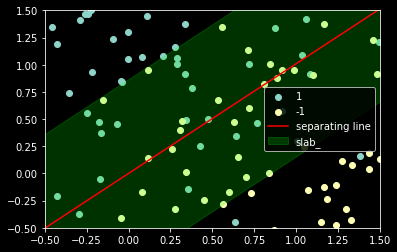

The accuracy of this model is 0.775


In [39]:

from sklearn.svm import SVC
skl_svm = SVC(kernel = 'linear')
skl_svm.fit(x_train, y_train)

x_coords = np.array([-0.6,1.6])
find_y = lambda x,w,b : (-b-w[0]*x)/w[1]

fig,ax = plt.subplots()
ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.5,1.5)
ax.scatter( x_train[ y_train == 1, 0], x_train[y_train == 1, 1], label = 1)
ax.scatter( x_train[ y_train == -1, 0], x_train[y_train == -1, 1], label = -1)

ax.plot( x_coords, find_y(x_coords, skl_svm.coef_[0], skl_svm.coef0), label = "separating line", color='red' )
dist = 1/skl_svm.coef_[0][1]
ax.fill_between(x_coords, find_y(x_coords, skl_svm.coef_[0], skl_svm.coef0) - dist, find_y(x_coords, skl_svm.coef_[0], skl_svm.coef0)+dist, label = "slab_", edgecolor = None, alpha=0.2, color='lime')
ax.legend()
plt.show()

print(f"The accuracy of this model is {np.mean( skl_svm.predict(x_test) == y_test )}")